In [3]:
NORMAL_MESSAGES = [
    "Good morning! How are you?",
    "Are you going to New York tomorrow?",
    "I hate it when it rains in New York!", # Getting tricky
    "It's too hot in here!", # Talking, of course, about being indoors.
    "Does anyone else think it's too hot in here?",
    "What's your favorite show on The Weather Channel?", # We're not talking about the weather.
]

FORECAST_MESSAGES = [
    "What's the weather forecast today for New York?",
    "Is it going to snow this week in New York?",
    "What's the high going to be tomorrow in New York?",
]

# First up - There's Currently Not a Yes/No Binary Model

I mean, it would be so tempting to just go,

```python
response = model({
    "question": "Is this person asking about the weather forecast?",
    "context": "Is it going to snow this week in New York?",
}) # outputs => "yes", or even better `True`
```

However, there's no such thing. I suppose since human text is so nuanced it would be dangerous for an AI model to make a binary determination like that.

So, we have to think outside the box on this one.

Perhaps we can detect the topic from the question. If it's something like "weather_forecast" we can proceed!

# Choosing the Right Model

For this we'll use the "zero-shot classification" task.

In order for the model to be viable, I'll use the following metrics:

1. The model should return a weather-related category for questions like
   - What's the forecast in New York for tomorrow?
   - Is it going to rain in New York tomorrow?
   - What's the high in New York this Friday?
2. The model should **not** return a weather-related category for questions like
   - How do you keep your hair dry in the rain?
   - What do you do to weather the storms of life?
   - What's your favorite show on The Weather Channel?
   - What's worse: snow or rain?

Note I'm focusing only on questions here. Determining if a sentence is a question is a pretty straight-forward task and we'll get to it later. So "I hate it when it snows in New York!" will not constitute a weather-related question.

Also note that I focus heavily on rooting out the false positive statements. I realize I'm not rooting them all out, but it's a start for this tutorial.

For now, let's try [zero-shot classifications with topics](https://huggingface.co/models?pipeline_tag=text-classification&sort=trending&search=topic) first. If you have a huggingface account, you cane experiment with these tokens on the model page.

One of the top "topic" classifications is **jonaskoenig/topic_classification_04**. Testing out a simple question like "What's the weather in New York tomorrow?" is less than promising:

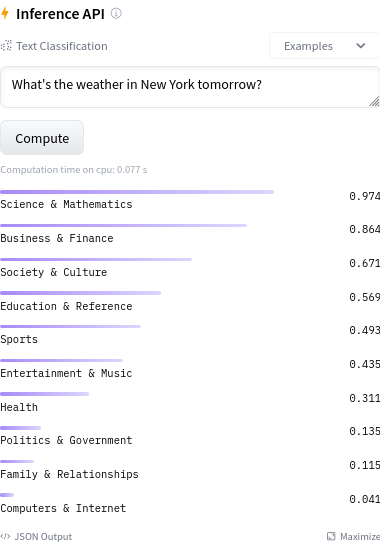

If anything, the question is more closely related to "Health" than "Science and Mathematics." So that won't do.

Let's check out [facebook/bart-large-mnli](https://huggingface.co/facebook/bart-large-mnli). It's a different type of zero-shot classification mechanism that takes *Text to classify* and *Possible class names*.

Let's start by trying to coerce the model to return a boolean value. Let's start with the values `weather forecast`, `other`.

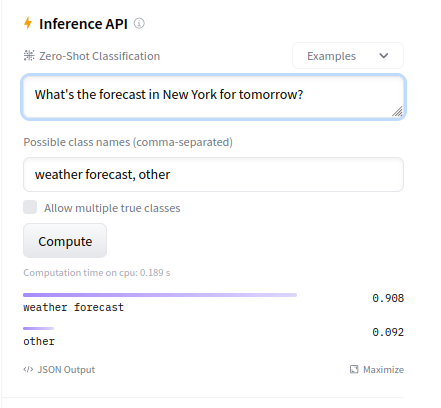
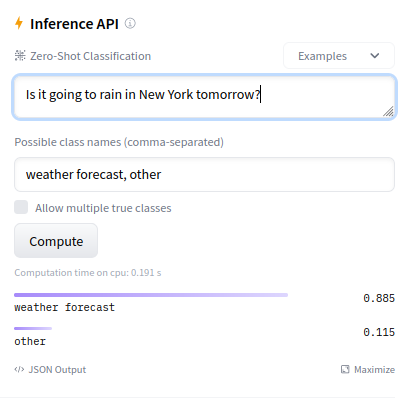
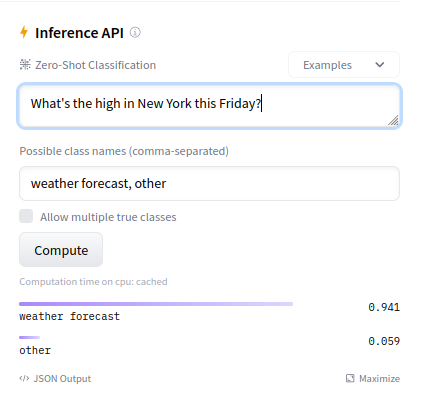

So far so good. Let's try some of the tricky false negatives we wanted to test:

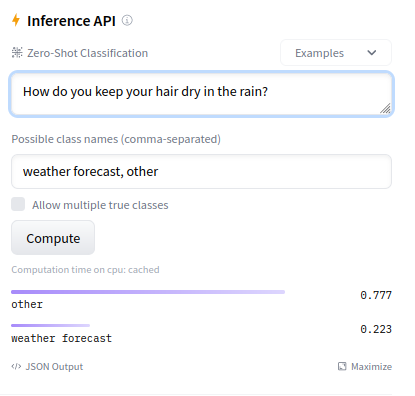
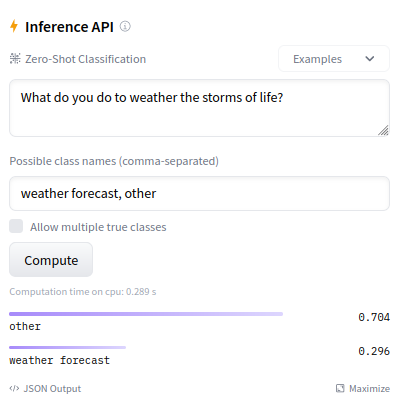
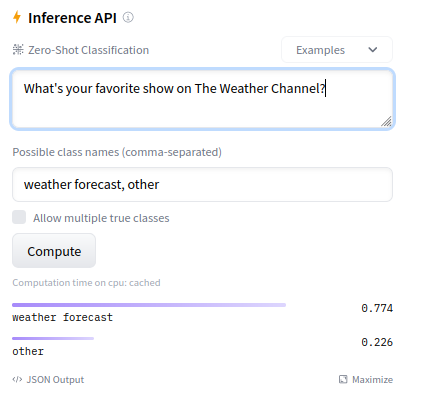
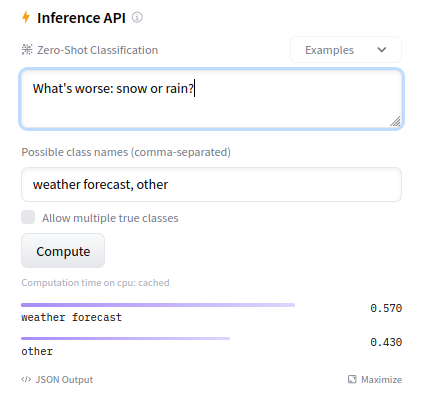

Alright, so didn't do so well for the last 2. How can we accomodate this?

Let's try adding some false negative categories to catch these. The ones I've chosen are: `weather forecast`, `comparison`, `opinion`, `television`, and, of course, our old favorite `other`.

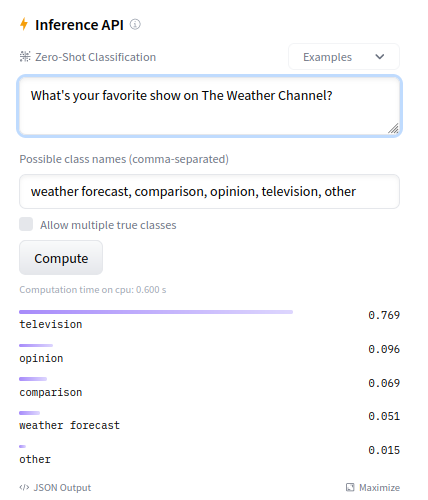
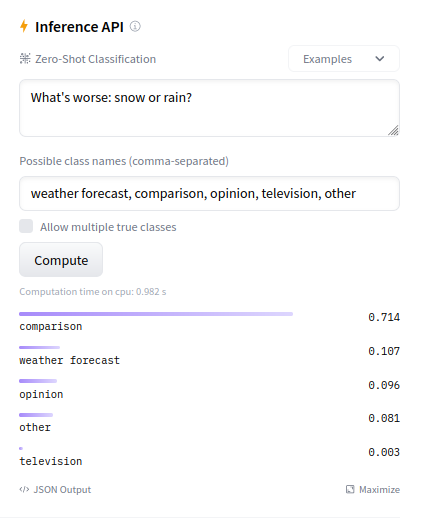

Nice! And just to verify, let's run through the true positives. 

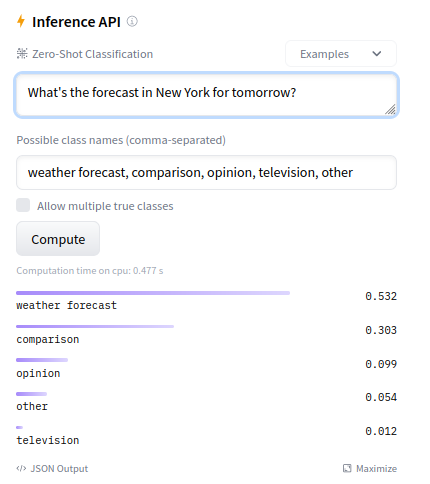
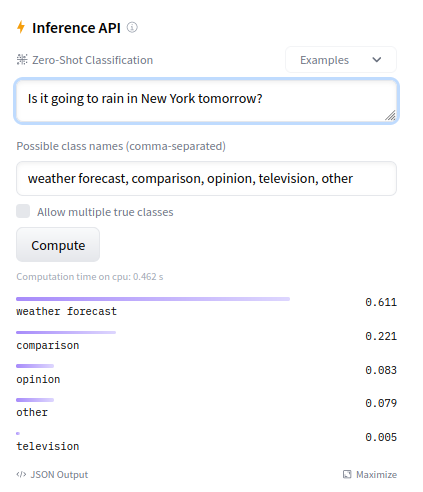
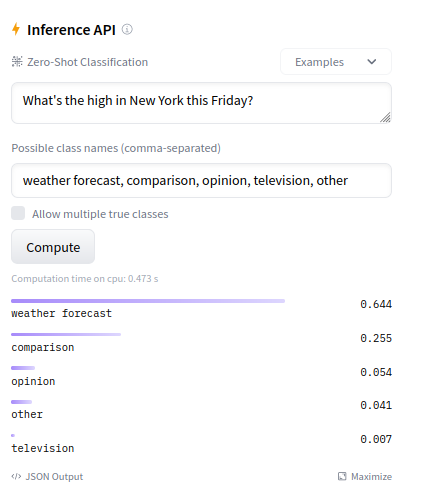

So, looks like **facebook/bart-large-mnli** is good enough for our purposes. Let's set it as a constant for our program.

In [4]:
FORECAST_CLASSIFICATION_MODEL = "facebook/bart-large-mnli"

# Type of Sentence

Before we can determine the weather forecast classification, we need to first determine if the sentence is a statement or a question. This would filter out sentences like "I hate it when it snows in New York!"

We could use the same classification model and use `question`, `statement` classifiers, but I'd prefer to use a model already trained on this specific task. One I found is [huaen/question_detection](https://huggingface.co/huaen/).

In [5]:
QUESTION_DETECTION_MODEL = "huaen/question_detection"

So then from here we can load our models.

In [6]:
from transformers import pipeline

sentence_pipe = pipeline("text-classification", model=QUESTION_DETECTION_MODEL)
forecast_pipe = pipeline("zero-shot-classification", model=FORECAST_CLASSIFICATION_MODEL)

# Determining If a (1) Question is asking about (2) The Weather

So, here is a python function for determining the Golden Question.

In [7]:
import typing as T # I like to do this ;-)

CLASSIFIERS = [
    "weather forecast",
    "comparison",
    "opinion",
    "television",
    "other",
]

class ClassifierOutput(T.TypedDict):
    sequence: T.AnyStr
    labels: T.Iterable[T.AnyStr]
    scores: T.Iterable[float]

def max_label_2(classifier_output : ClassifierOutput):
    max_score = -1
    max_label = None
    for label, score in zip(classifier_output['labels'], classifier_output['scores']):
        if score > max_score:
            max_score = score
            max_label = label
    return max_label

def is_asking_for_forecast(text : T.AnyStr):
    # Returns True if the text is a question and asking about the weather.
    if sentence_pipe(text)[0]["label"].lower() != "question":
        return False
    labels = forecast_pipe(text, CLASSIFIERS)
    # In cases like this I prefer using "in", just in case we add other items.
    return max_label_2(labels).lower() in ("weather forecast",)

# Now let's run it through our test cases

print("These should return False")
print("="*20)
for message in NORMAL_MESSAGES:
    is_forecast = is_asking_for_forecast(message)
    print(f'"{message}" => {is_forecast}')

print("These should return True")
print("="*20)
for message in FORECAST_MESSAGES:
    is_forecast = is_asking_for_forecast(message)
    print(f'"{message}" => {is_forecast}')

These should return False
"Good morning! How are you?" => False
"Are you going to New York tomorrow?" => False
"I hate it when it rains in New York!" => False
"It's too hot in here!" => False
"Does anyone else think it's too hot in here?" => False
"What's your favorite show on The Weather Channel?" => False
These should return True
"What's the weather forecast today for New York?" => True
"Is it going to snow this week in New York?" => True
"What's the high going to be tomorrow in New York?" => True


And looks like they do!

Next up, we need to find 2 things in order to get a forecast:

1. Temporal information. Temporal meaning "date and time" type stuff. This might be a bit tricky.
2. Determine the user's location from the context. This is a lot easier.

# Extracting the Date and Time

For a start we need to extract the date like object. Extraction of these features usually calls for **Token Classification**. After looking for a proper model, the one I happened across was [satyaalmasian/temporal_tagger_BERT_tokenclassifier](https://huggingface.co/satyaalmasian/temporal_tagger_BERT_tokenclassifier?text=What%27s+the+weather+like+in+New+York+this+Friday%3F). This seems to do the trick. In the test I supplied the model was able to pick up **this Friday** as a date.

Let's use it as a pipe.

In [8]:
TEMPORAL_TAGGER_MODEL = "satyaalmasian/temporal_tagger_BERT_tokenclassifier"
temporal_pipe = pipeline("token-classification", model=TEMPORAL_TAGGER_MODEL)

Just to see what kinds of output we get, let's run it through our messages again.

In [9]:
import pprint
print("Forecast messages:")
for message in FORECAST_MESSAGES:
    result = temporal_pipe(message)
    print(f'"{message}"')
    pprint.pprint(result)

Forecast messages:
"What's the weather forecast today for New York?"
[{'end': 33,
  'entity': 'B-DATE',
  'index': 7,
  'score': 0.9994288,
  'start': 28,
  'word': 'today'}]
"Is it going to snow this week in New York?"
[{'end': 24,
  'entity': 'B-DATE',
  'index': 6,
  'score': 0.99959654,
  'start': 20,
  'word': 'this'},
 {'end': 29,
  'entity': 'I-DATE',
  'index': 7,
  'score': 0.99969256,
  'start': 25,
  'word': 'week'}]
"What's the high going to be tomorrow in New York?"
[{'end': 36,
  'entity': 'B-DATE',
  'index': 9,
  'score': 0.999592,
  'start': 28,
  'word': 'tomorrow'}]


Okay, great. But these are still words. We need to make sense of them.

This is where we'll have to roll up our sleeves and take advantage of that prompt energy.

# Testing with text-generation-webui (TGW)

I'm sure you can use any text-to-text app for this. I've taken a liking to TGW, though.

In TGW I selected a fairly small model 
([TheBloke_airoboros-l2-7B-gpt4-2.0-GGUF](https://huggingface.co/TheBloke/airoboros-l2-7B-gpt4-2.0-GGUF))
and then went to the **Default** tab

Believe it or not we can coerce an LLM engine to output in a specific format. If you're using this article for something more advanced, I'd *highly* recommend using JSON format, as
[LLMs are known to produce syntactically-correct JSON 100% of the time](https://news.ycombinator.com/item?id=37125118).

Within the **Default** tab, I provide the following input for the **Textbox**:

```
You can only reply in raw UNIX timestamps or "None." You must calculate an OUTPUT TIMESTAMP based on a CURRENT TIMESTAMP and a DELTA specified by a human. If you are unable to reply with UNIX timestamp, you must reply with the value "None."

CURRENT TIMESTAMP:
DELTA:
OUTPUT TIMESTAMP:
```

And run it through a few tests...

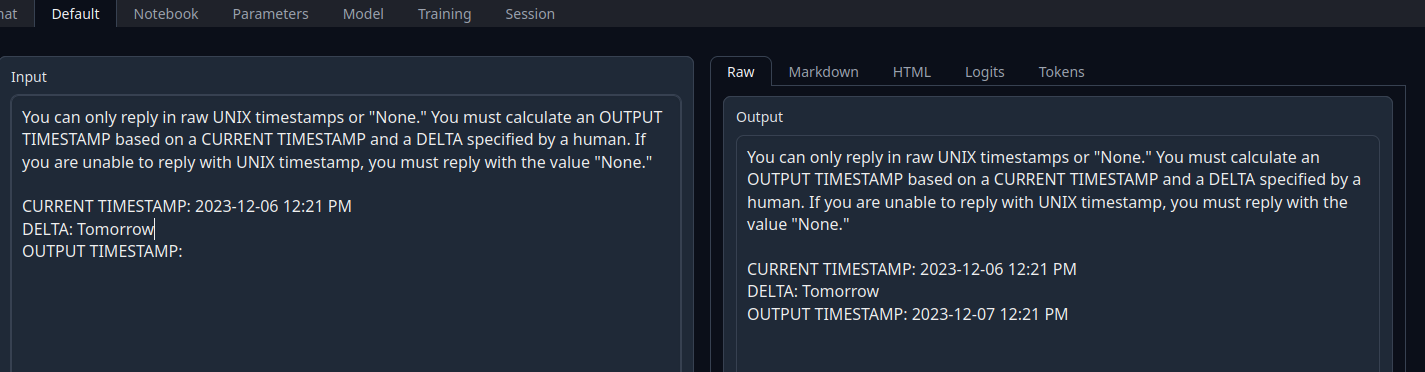
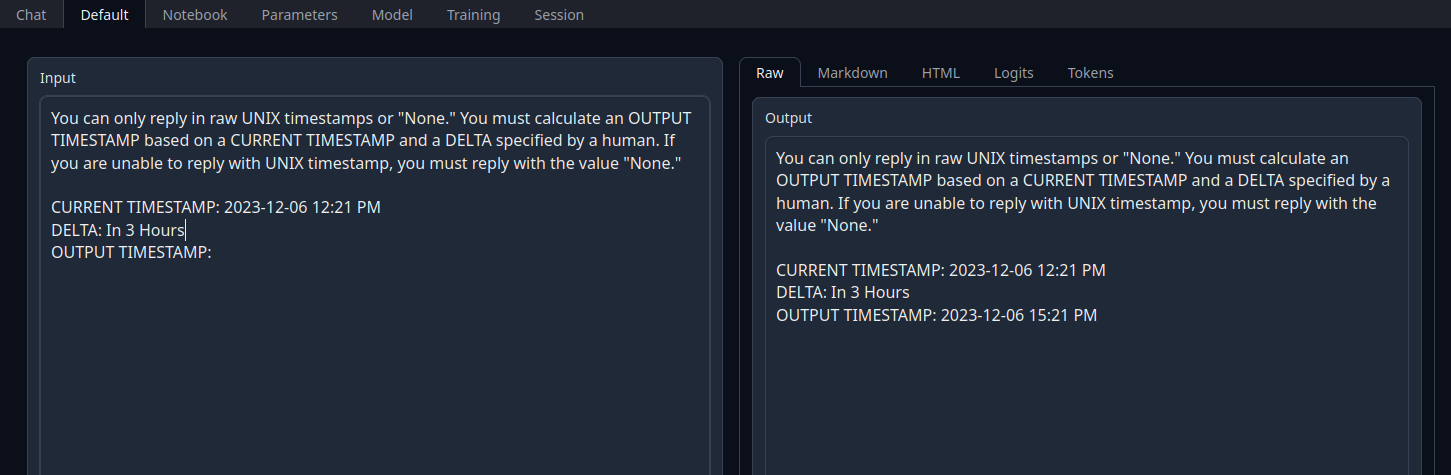
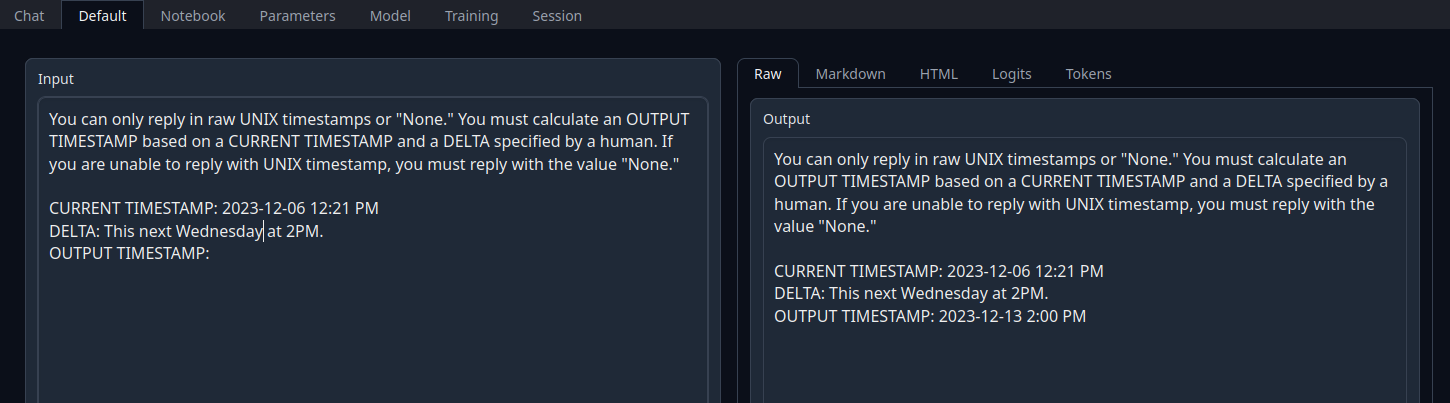

Something interesting happens if we pass it a curveball:

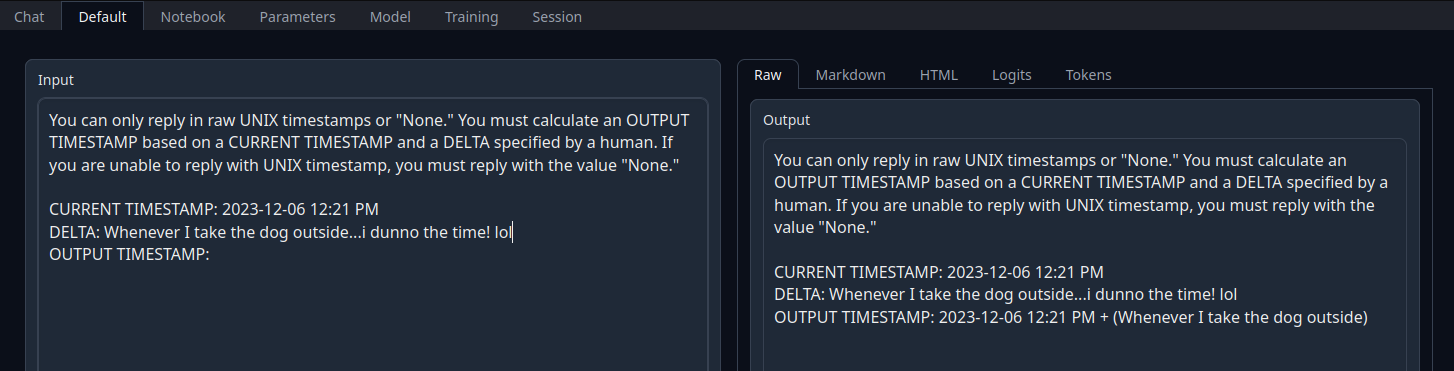

This isn't exactly what I had in mind, but we can work with it. All that matters is that we have (accurate) unix timestamp as output.

# Combining Temporal Tokens With the Calculated Future Date

I like the **TheBloke/airoboros-l2-7B-gpt4-2.0-GGUF** model. I'll be cheating a little bit here. I've tried a few on-the-fly models and each one has lead to a system freeze, so I'll just load up the model I already have saved from textgeneration-webui.

In [10]:
from pathlib import Path
import os
from ctransformers import AutoModelForCausalLM as CAutoModelForCausalLM
from dotenv import load_dotenv

load_dotenv()

assert os.getenv("AIROBOROS_PATH") is not None, "Set the AIROBORS_PATH environment variable"
LLM_MODEL = Path(os.getenv("AIROBOROS_PATH")).resolve()
assert LLM_MODEL.exists()

DATE_CALCULATOR_TEMPLATE = """You can only reply in raw UNIX timestamps or "None." You must calculate an OUTPUT TIMESTAMP based on a CURRENT TIMESTAMP and a DELTA specified by a human. If you are unable to reply with UNIX timestamp, you must reply with the value "None."

CURRENT TIMESTAMP: {current_timestamp}
DELTA: {delta}
OUTPUT TIMESTAMP:"""

# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL)
model = CAutoModelForCausalLM.from_pretrained("TheBloke/airoboros-l2-7B-3.0-GGUF",
                                             model_file=str(LLM_MODEL / "airoboros-l2-7B-gpt4-2.0.Q4_K_M.gguf"),
                                              model_type="llama",
                                              gpu_layers=0,
                                              max_new_tokens=2048,
                                              context_length=2048)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Fetching 0 files: 0it [00:00, ?it/s]

In [11]:
from datetime import datetime, timedelta
import typing as T

TIMESTAMP_FORMAT = "%Y-%m-%d %I:%M %p"

def get_intentioned_time_from_delta(delta : T.AnyStr, current_timestamp=None):

    current_timestamp = current_timestamp or (datetime.now().strftime(TIMESTAMP_FORMAT))

    prompt = DATE_CALCULATOR_TEMPLATE.format(current_timestamp=current_timestamp, delta=delta)
    response = model(prompt)

    # Extract only the output timestamp
    out_ts_text = response.split("OUTPUT TIMESTAMP:")[-1].strip().rstrip()

    # Make sure the output text can be parsed correctly.
    try:
        return datetime.strptime(out_ts_text, TIMESTAMP_FORMAT)
    except Exception as e:
        print(e)
        return None

# Now let's run through some tests
current_timestamp = "2023-12-06 4:20 PM"
messages = [
    "tomorrow morning",
    "next week",
    "today in 2 hours",
    "monkey biscuits!!!",
]
for message in messages:
    intentioned_time = get_intentioned_time_from_delta(message, current_timestamp)
    print(f'"{message}" => {intentioned_time}')

"tomorrow morning" => 2023-12-07 04:20:00
"next week" => 2023-12-13 16:20:00
"today in 2 hours" => 2023-12-08 16:20:00
"monkey biscuits!!!" => 2023-12-07 10:55:00


Apparently "Monkey bicuits!!!" means "in 4 hours!" Who knew?

Probably if this was a legitimate produdct I'd vie for trying to make the "monkey biscuits!!!" case `None`. But I'll leave it be for now (perhaps a good prompt engineering assignment for the reader!). Let's move on. Now, how do we get the `delta` value?

If you remember (or scroll back up to--for our ADHD folks like me!) the output from **Extracting the Date and Time** above, then you saw that when we extracted the keywords, they were in a list of dicts, sometimes with just one item.

Since (in our text-generation-webui tests) the values like `in 3 days` worked, let's just string together the delta values as the delta.

In [12]:
def get_delta_value(message : T.AnyStr):
    return ' '.join([t["word"] for t in temporal_pipe(message)])

Now let's test out our `get_delta_value` function.

In [13]:
messages = [
    "Is it going to rain tomorrow?",
    "What's the high temperature on wednesday of next week?",
    "Is it going to be cold today?",
]
for message in messages:
    dv = get_delta_value(message)
    print(f'"{message}" => "{dv}"')

"Is it going to rain tomorrow?" => "tomorrow"
"What's the high temperature on wednesday of next week?" => "wednesday next week"
"Is it going to be cold today?" => "today"


Looks good. Finally, we're ready to determine the date that's offset from the timestamp! Let's go!

In [14]:
def determine_intentioned_time_from_message(message, now=None):
    now = now or datetime.now()
    now_ts = now.strftime(TIMESTAMP_FORMAT)

    # Extracts the delta value (e.g.) 
    delta = get_delta_value(message)

    intention_timestamp = get_intentioned_time_from_delta(delta, now_ts)
    return intention_timestamp


# Now let's test it!
current_time = datetime(2023, 12, 6, 4) # Yay! We can use datetime now!
messages = [
    "Is it going to rain tomorrow in New York?",
    "What's the high temperature on wednesday of next week in New York?",
    "Is it going to be cold today in New York?",
    "Is it going to be cold when I walk my dog in New York?",
]
for message in messages:
    intentioned_time = determine_intentioned_time_from_message(message, current_time)
    print(f'"{message}" => {intentioned_time}')

"Is it going to rain tomorrow in New York?" => 2023-12-07 04:00:00
"What's the high temperature on wednesday of next week in New York?" => 2023-12-06 16:00:00
"Is it going to be cold today in New York?" => 2023-12-06 05:00:00
"Is it going to be cold when I walk my dog in New York?" => 2023-12-06 05:00:00


So it seems sadly no LLM can yet tell me how cold it is when I walk my dog. :-(

# Extracting Entities

What are entities you ask?

Jack Nickleson, Miranda Lambert, The Flintsones, CNN!...Basically, "official" tokens.

For that we'll use the
[mdarhri00/named-entity-recognition](https://huggingface.co/mdarhri00/named-entity-recognition)
model for extracting named entities.

Let's load *that* into the pipeline.

In [15]:
ENTITY_MODEL = "mdarhri00/named-entity-recognition"
ENTITY_MESSAGES = [
    "Is it going to rain tomorrow in New York?",
    "Is it going to rain tomorrow in Liverpool?",
    "Is it going to rain tomorrow in South Africa?",
    "Is it going to rain tomorrow in Ouagadougou?", # Capital of Burkina Faso ;-)
    "Is it going to rain tomorrow in D3velsla1r?", # Um....
]

# Add the entity model to the pipeline
entity_pipe = pipeline("token-classification", model=ENTITY_MODEL)
    
def extract_location(message: T.AnyStr):
    location = ""
    for e in entity_pipe(message):
        if e["entity"] == "location":
            location += " " + e["word"]
    return location.strip().rstrip() or None

# Now let's test it!
for message in ENTITY_MESSAGES:
    name = extract_location(message)
    print(f'"{message}" => "{name}"')

"Is it going to rain tomorrow in New York?" => "New York"
"Is it going to rain tomorrow in Liverpool?" => "Liverpool"
"Is it going to rain tomorrow in South Africa?" => "South Africa"
"Is it going to rain tomorrow in Ouagadougou?" => "Ou ##aga ##dou ##gou"
"Is it going to rain tomorrow in D3velsla1r?" => "None"


**Note:** The above code does definitely have an issue, namely that it's assuming only *one* entity exists in the sentence. So therefore, something like, "I'm travling from New York to London, what's the weather like next week?" would result in the single entity detecting being `New York London`. To fix this, you'd essentially need to finding groupsings of the entities. But it's getting late and I'm too lazy for that now. 😝

# Using AI to Find the GPS Coordinates From an Entity Location

If it was 2016 I'd say we need to do reverse geocoding, which would either entail:

- Signing up for a reverse geocoding service, or
- Spinning up an instance of OpenStreetmaps in Docker

But it's 2023 (going on 2024). In the age of AI, we don't need this.

In fact, we can reuse the **Intel/neural-chat-7b-v3-1** model to do this very thing.

I won't bore you with the details, but I ran through a bunch of prompt templates in TGW, and came up with the following prompt:

```
You can only respond in raw json format. Answer any question asked of you. Return the GPS COORDINATES of a given LOCALE in the form `{"lat": number, "lon": number}`. Use your best guess. Think outside the box. Only provide one response.

LOCALE: %(locale)s
GPS COORDINATES:
```

Note that for the Python template, we should use the '%' form of the Python string to avoid conflicts with the JSON schema definition.

For testing, though I threw in a few city and even country names, and it did a pretty bang-up job returning the GPS locations.

So now we can define our own reverse geocode function.

In [16]:
import json

GEOCODE_TEMPLATE="""You can only respond in raw json format. Answer any question asked of you. Return the GPS COORDINATES of a given LOCALE in the form `{"lat": number, "lon": number}`. Use your best guess. Think outside the box. Only provide one response.

LOCALE: %(locale)s
GPS COORDINATES:"""

def reverse_geocode(location_name : T.AnyStr):

    prompt = GEOCODE_TEMPLATE % {"locale": location_name}

    response = model(prompt)

    coordinate_str = response.split("GPS COORDINATES: ")[-1].strip().rstrip()

    # In production you should probably do something if it can't be parsed.
    # for now we'll just swallow the error.
    try:
        return json.loads(coordinate_str)
    except Exception as err:
        print(err)
        return None

# Let's try it out:

LOCATIONS = [
    "Sydney",
    "London",
    "New York",
    "South Africa",
    "D3velsla1r",
]

for location in LOCATIONS:
    coords = reverse_geocode(location)
    if coords:
        print(f'"{location}" => {coords["lat"]}, {coords["lon"]}')
    else:
        print(f'"{location}" => None')

"Sydney" => -33.8675, 151.2098
"London" => 51.5072, -0.1277
"New York" => 40.7127, -73.9614
"South Africa" => -34.027165, 18.975735
"D3velsla1r" => 50.496827, -10.757556


And now we know where D3velsla1r is!

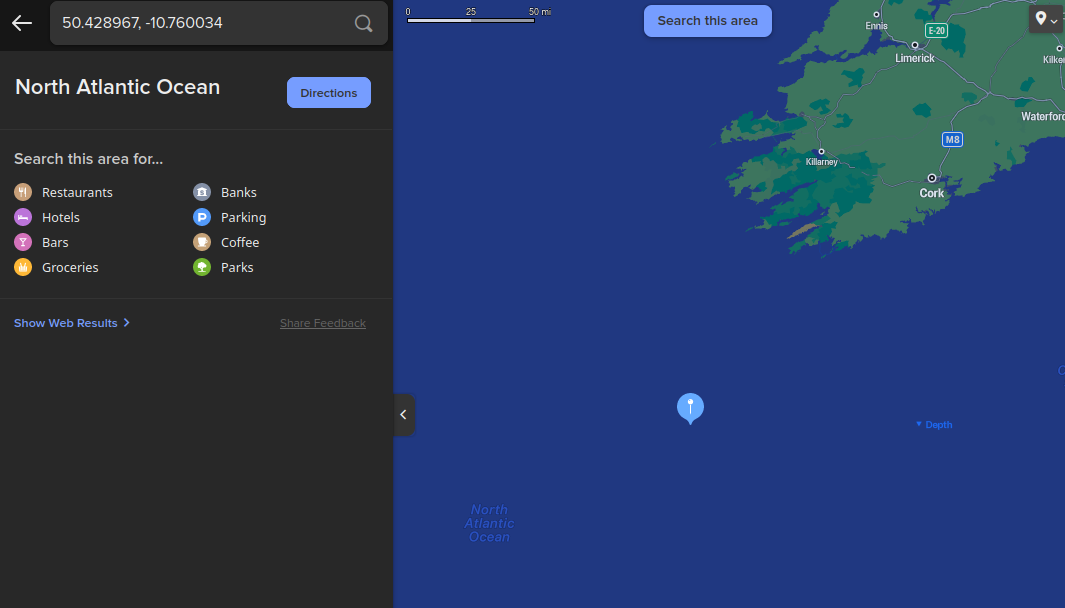

Again, I wouldn't worry too much about this because the user in the message would already need to have gotten past the question check, the topical check, and the date/time check. If they're really concerned about the weather tomorrow in "D3velsla1r," more power to 'em!

Note that this reverse geocode method won't work for locations where there's a name conflict (e.g. Portland, OR vs. Portland, ME), but that's been an issue with standard reverse geocoding as well. You'd have to explicitly put in the thing that breaks the conflict (i.e. the state) or the more popular one will win out (Portland, OR).

# Fetching The Data From OpenWeatherMaps

Now we can extract everything we need to get the weather from OpenWeatherMaps:

- The date and time of the forecast
- The GPS coordinates of the intended location.

Let's start querying OpenWeatherMap.

In [22]:
import os
import requests
import json

# Get the API key from the environment variable
API_KEY = os.getenv("METEOSOURCE_API_KEY")

# I'm making it an underscore method because the actual `get_weather` will do the heavy lifting.
def _get_weather(lat, lon):
    
    # Create the URL for the forecast request
    url = f"https://www.meteosource.com/api/v1/free/point?lat={lat}&lon={lon}&sections=all&timezone=UTC&language=en&units=metric&key={API_KEY}"
    
    # Send the request and get the response
    response = requests.get(url, headers={"Content-Type": "application/json"})

    response.raise_for_status()
    
    return response.json()

# Let's test it!
pprint.pprint(_get_weather(12.4795, 98.2425))

{'current': {'cloud_cover': 58,
             'icon': 'mostly_cloudy',
             'icon_num': 29,
             'precipitation': {'total': 0.0, 'type': 'none'},
             'summary': 'Mostly cloudy',
             'temperature': 27.0,
             'wind': {'angle': 108, 'dir': 'ESE', 'speed': 0.9}},
 'daily': {'data': [{'afternoon': None,
                     'all_day': {'cloud_cover': {'total': 60},
                                 'icon': 13,
                                 'precipitation': {'total': 2.6,
                                                   'type': 'rain'},
                                 'temperature': 27.5,
                                 'temperature_max': 29.5,
                                 'temperature_min': 26.5,
                                 'weather': 'rain_shower',
                                 'wind': {'angle': 240,
                                          'dir': 'WSW',
                                          'speed': 1.3}},
                  

To keep things simple I'll just use an example of json output I already obtained from meteosource:

In [25]:
import json

_orig_get_weather = _get_weather

METEOSOURCE_EXAMPLE = Path(".") / "example-meteosource.json"

def _get_weather(lat, lon):
    if not METEOSOURCE_EXAMPLE.exists():
        print("Example file not found...using metesource")
        return _orig_get_weather(lat, lon)
    return json.loads(METEOSOURCE_EXAMPLE.read_text())

pprint.pprint(_get_weather(12.4795, 98.2425))

{'current': {'cloud_cover': 54,
             'icon': 'mostly_cloudy',
             'icon_num': 5,
             'precipitation': {'total': 0.0, 'type': 'none'},
             'summary': 'Mostly cloudy',
             'temperature': 11.2,
             'wind': {'angle': 239, 'dir': 'WSW', 'speed': 15.1}},
 'daily': {'data': [{'afternoon': None,
                     'all_day': {'cloud_cover': {'total': 68},
                                 'icon': 13,
                                 'precipitation': {'total': 7.8,
                                                   'type': 'rain'},
                                 'temperature': 12.0,
                                 'temperature_max': 13.2,
                                 'temperature_min': 11.0,
                                 'weather': 'rain_shower',
                                 'wind': {'angle': 231,
                                          'dir': 'SW',
                                          'speed': 14.1}},
                  

Next up we write `get_weather` which will do the heavy lifting.

In [30]:
def get_weather(message : T.AnyStr):
    if not is_asking_for_forecast(message):
        print("Not asking for forecast")
        return None
    timestamp = determine_intentioned_time_from_message(message)
    if not timestamp:
        print("could not determine timestamp")
        return None

    location = extract_location(message)
    lat_long = reverse_geocode(location)
    if not lat_long:
        print("Could not determine location")
        return None
    return _get_weather(lat_long["lat"], lat_long["lon"])

print(get_weather("What's the forecast in Seattle for today?"))

{'lat': '50.428967N', 'lon': '10.760034W', 'elevation': 0, 'timezone': 'UTC', 'units': 'metric', 'current': {'icon': 'mostly_cloudy', 'icon_num': 5, 'summary': 'Mostly cloudy', 'temperature': 11.2, 'wind': {'speed': 15.1, 'angle': 239, 'dir': 'WSW'}, 'precipitation': {'total': 0.0, 'type': 'none'}, 'cloud_cover': 54}, 'hourly': {'data': [{'date': '2023-12-07T15:00:00', 'weather': 'partly_sunny', 'icon': 4, 'summary': 'Partly sunny', 'temperature': 11.2, 'wind': {'speed': 15.1, 'dir': 'WSW', 'angle': 239}, 'cloud_cover': {'total': 54}, 'precipitation': {'total': 0.0, 'type': 'none'}}, {'date': '2023-12-07T16:00:00', 'weather': 'mostly_cloudy', 'icon': 5, 'summary': 'Mostly cloudy', 'temperature': 11.2, 'wind': {'speed': 14.7, 'dir': 'WSW', 'angle': 239}, 'cloud_cover': {'total': 74}, 'precipitation': {'total': 0.0, 'type': 'none'}}, {'date': '2023-12-07T17:00:00', 'weather': 'rain_shower', 'icon': 32, 'summary': 'Rain shower', 'temperature': 11.2, 'wind': {'speed': 14.8, 'dir': 'WSW', '

Note that since I'm loading the forecast from a file the location isn't accurate, but it will be if the file was missing. But for our purposes, it's good enough. Moving on!

Next, let's define some formatting functions that we can use to embed the forecast in the prompt.

In [39]:
HOURLY_DATE_FORMAT = "%Y-%m-%dT%H:%M:%S"
WEATHER_DAY_FORMAT = "%Y-%m-%d"
HUMAN_TIME = "%-1H %p"
HUMAN_DATE = "%A %B %-1d" # We don't need the year.

def _dt_format_convert(from_dt_str, from_fmt, to_fmt):
    from_dt = datetime.strptime(from_dt_str, from_fmt)
    return from_dt.strftime(to_fmt)

def _format_hourly_forecast(hourly_forecast):
    h = hourly_forecast
    hourly_date = _dt_format_convert(h["date"], HOURLY_DATE_FORMAT, HUMAN_TIME)
    summary = h["summary"]
    temp = f"{h['temperature']}ºC"
    wind = f"{h['wind']['dir']} at {h['wind']['speed']} km/h"
    cloud = f"{h['cloud_cover']['total']}% cloud cover"
    precip_type = h['precipitation']['type']
    precip = f"{h['precipitation']['total']} cm {precip_type}" if precip_type == "none" else ""
    return f"{hourly_date}: {temp}, {cloud}, {precip} wind {wind}"

def _format_daily_forecast(daily_forecast):
    d = daily_forecast
    daily_date = _dt_format_convert(d["day"], WEATHER_DAY_FORMAT, HUMAN_DATE)
    return f"{daily_date}: {d['summary']}"

def _format_current_conditions(current_conditions):
    c = current_conditions
    temp = f"{c['temperature']}ºC"
    wind = f"{c['wind']['dir']} at {c['wind']['speed']} km/h"
    cloud = f"{c['cloud_cover']} % cloud cover"
    return f"{c['summary']}, {temp}, wind {wind}, {cloud}"

def format_current_conditions(forecast):
    return _format_current_conditions(forecast["current"])

def format_hourly_forecasts(forecast, skip=2):
    f = forecast["hourly"]["data"]
    return "\n".join([_format_hourly_forecast(f[i]) for i in range(0, len(f), skip)])

def format_daily_forecasts(forecast, skip=2):
    f = forecast["daily"]["data"]
    return "\n".join([_format_daily_forecast(f[i]) for i in range(0, len(f), skip)])

# Let's test the format before committing to our AI functions

forecast = _get_weather(12.4795, 98.2425)

print("== current conditions ==")
print(format_current_conditions(forecast))

print("== hourly forecast ==")
print(format_hourly_forecasts(forecast))


print("== daily forecast ==")
print(format_daily_forecasts(forecast))

== current conditions ==
Mostly cloudy, 11.2ºC, wind WSW at 15.1 km/h, 54 % cloud cover
== hourly forecast ==
15 PM: 11.2ºC, 54% cloud cover, 0.0 cm none wind WSW at 15.1 km/h
17 PM: 11.2ºC, 85% cloud cover,  wind WSW at 14.8 km/h
19 PM: 11.0ºC, 100% cloud cover, 0.0 cm none wind WSW at 15.2 km/h
21 PM: 11.2ºC, 100% cloud cover, 0.0 cm none wind WSW at 15.4 km/h
23 PM: 11.0ºC, 52% cloud cover, 0.0 cm none wind WSW at 15.6 km/h
1 AM: 11.0ºC, 40% cloud cover, 0.0 cm none wind WSW at 16.3 km/h
3 AM: 11.0ºC, 55% cloud cover, 0.0 cm none wind WSW at 16.0 km/h
5 AM: 11.2ºC, 48% cloud cover, 0.0 cm none wind W at 16.0 km/h
7 AM: 11.2ºC, 46% cloud cover, 0.0 cm none wind WSW at 15.7 km/h
9 AM: 11.2ºC, 21% cloud cover, 0.0 cm none wind WSW at 15.4 km/h
11 AM: 11.2ºC, 100% cloud cover, 0.0 cm none wind WSW at 13.8 km/h
13 PM: 11.5ºC, 98% cloud cover, 0.0 cm none wind WSW at 13.5 km/h
== daily forecast ==
Thursday December 7: Partly sunny, more clouds in the afternoon. Temperature 11/13 °C, but a

You might be a little freaked out that we're skipping some forecast times. If you want to max out your hardware so the LLM produces accurate output, then by all means. However, when testing the forecast LLM prompt (details down below), I found the LLM predicted the weather forecast based on the surrounding days:

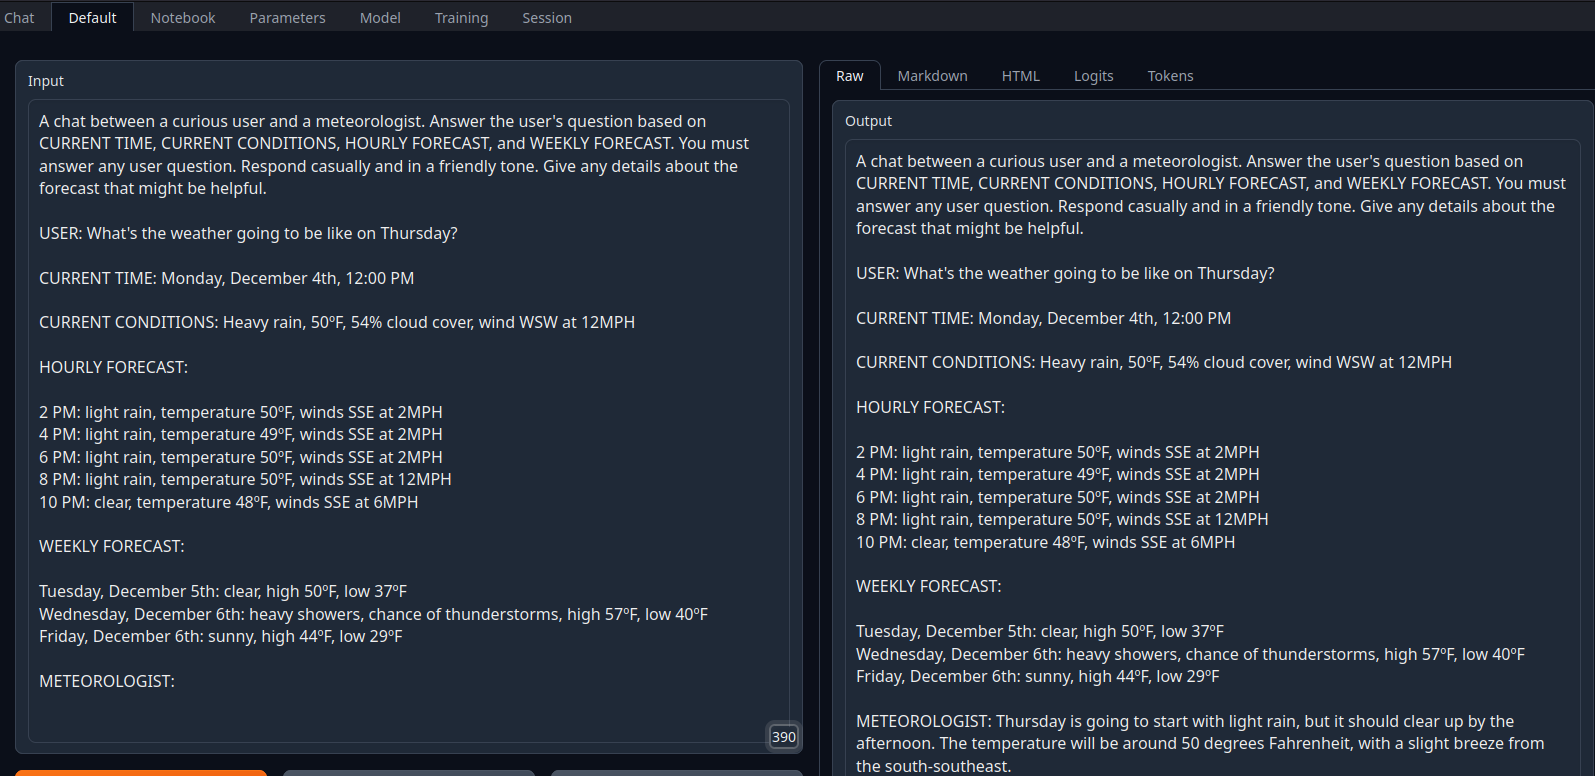

The way around this could be do pass in an `ensure_date` to the format_weather in order to ensure that if a user requested a certian day, then that day is accounted for (same for the time).

For now, though, I'll let it slide and move on to the pithy result.


# Almost to the Finish Line!

Let's embed this formatted forecast back into the user prompt.

However, I would not recommend modifying the original template. If it causes you anxiety, just remember that we've switched modes. We've given our conversation a special task. And for that task we need a special template.

The template I used is as follows:

```
A chat between a curious user and a meteorologist. Answer the user's question based on CURRENT TIME, CURRENT CONDITIONS, HOURLY FORECAST, and WEEKLY FORECAST. You must answer any user question. Respond casually and in a friendly tone. Give any details about the forecast that might be helpful.

USER: {user_input}

CURRENT TIME: {current_time}

CURRENT CONDITIONS: {current_conditions}

HOURLY FORECAST:

{hourly_forecast}

DAILY FORECAST:

{daily_forecast}

METEOROLOGIST:
```

From here we can get a meteorologist response:

In [54]:
METEOROLOGIST_TEMPLATE = """A chat between a curious user and a meteorologist. Answer the user's question based on CURRENT TIME, CURRENT CONDITIONS, HOURLY FORECAST, and DAILY FORECAST. You must answer any user question. Respond casually and in a friendly tone. Give any details about the forecast that might be helpful.

USER: {user_input}

CURRENT TIME: {current_time}

CURRENT CONDITIONS: {current_conditions}

HOURLY FORECAST:

{hourly_forecast}

DAILY FORECAST:

{daily_forecast}

METEOROLOGIST:"""

# This provides the fallback response if the user was not asking about the weather

VICUNA_TEMPLATE = """A chat between a curious user and an artificial intelligence assistant. The assistant gives helpful, detailed, and polite answers to the user's questions, and responds casually like with a friend.

USER: {message}
ASSISTANT:
"""

def _get_meteorologist_response(user_input : T.AnyStr,
                               current_time : T.AnyStr,
                               current_conditions : T.AnyStr,
                               hourly_forecast : T.AnyStr,
                               daily_forecast : T.AnyStr):
    """ Note this just composes the template. The values should already be formatted accordingly."""
    prompt = METEOROLOGIST_TEMPLATE.format(
        user_input=user_input,
        current_time=current_time,
        current_conditions=current_conditions,
        hourly_forecast=hourly_forecast,
        daily_forecast=daily_forecast,
    )
    response = model(prompt)
    answer = response.split("METEOROLOGIST: ")[-1].strip().rstrip()
    return answer

# Let's handle the value conversion in this function
def get_meteorologist_response(user_input : T.AnyStr,
                             current_time: datetime,
                             weather_forecast : T.Hashable):
    current_time_s = current_time.strftime(HUMAN_TIME)
    current_conditions = format_current_conditions(weather_forecast)
    hourly_forecast = format_hourly_forecasts(weather_forecast)
    daily_forecast = format_daily_forecasts(weather_forecast)
    return _get_meteorologist_response(
        user_input,
        current_time_s,
        current_conditions,
        hourly_forecast,
        daily_forecast,
    )

def get_default_response(message):
    prompt = VICUNA_TEMPLATE.format(
        message=message
    )
    response = model(prompt)
    answer = response.split("ASSISTANT: ")[-1].strip().rstrip()
    return answer

current_time = datetime(2023, 12, 7, 6)

def whole_enchalada_forecast(message : T.AnyStr, now=None):
    now = now or datetime.now()
    # Just basically do what we did to the tests...
    weather_forecast = get_weather(message)
    if not weather_forecast:
        # remember, this could just mean they weren't asking for the forecast.
        # In this case
        return get_default_response(message)
    else:
        return get_meteorologist_response(message, current_time, weather_forecast)
    
# Now let's test it!
messages = [
    "For the weather, is it raining right now in Anchorage, Alaska?",
    "What's the forecast for Florida next week?",
    "Why won't this work?",
    "I bet it's going to rain.",
]

for message in messages:
    print(">> The user asked:")
    print(f'"{message}"')
    print()
    response = whole_enchalada_forecast(message)
    print(">> The bot responded:")
    print(response)

>> The user asked:
"For the weather, is it raining right now in Ancorage, Alaska?"

>> The bot responded:
Yes, it is currently raining in Ancorage, Alaska.
>> The user asked:
"What's the forecast for Florida next week?"

>> The bot responded:
Florida's next week forecast looks interesting. We can expect a mix of sunny and cloudy days with occasional showers, particularly on Saturday. The strong winds are also noteworthy, especially on Thursday when gusts may reach up to 21 m/s. However, by Monday the weather should start improving, becoming mostly sunny but still a bit cooler.
>> The user asked:
"Why won't this work?"

Not asking for forecast
>> The bot responded:
```python
def print_name(user):
    return f"Hello, {user.name}!"

class User(object):
    def __init__(self, name):
        self.name = name

    def greet(self):
        return print_name(self)
```

In this code, the `print_name` function works as expected when called with an argument (`user`). It returns a string with 'Hel

Now if we were programming a chat bot, the generated text would be sent back to the user for visible display.

# Conclusion

This article walked through how to determine if a message filled certain parameters for kicking off another LLM task. These parameters were (1) Is this message even a question, and is this a (2) 'weather_forecast' question.

Next, we used entity recognition to extract the locale information from the message. we then coerced an LLM to spit back a JSON object that represented the latitude and longitude coordinates of that location. Using those coordinates, we used that to query a map API and return back the weather.

Overall I walked through various strategies for using subsequent AI tasks for fulfilling your primary AI task. In AI, not everything is an LLM, but you can use LLMs to do seemingly non-LLM work. In many instances, though, we had to think creatively to make an AI model create a result we desired.

In this article I provided the example of using the weather forecast for interfacing with the user. But only use this as a launching point. You probably have other tasks that you need done for your business, such as:

- Fetching Jira tickets and determining who's assigned to them.
- Analyzing styles, colors, and other clothing attributes, then creating an AI-generated image using those attributes
- Using sentiment analysis on a user chat; if they're upset, finding out what happened in their account to make them upset.
- Analyzing a user's uploaded photo to determine how "award-worthy" the photo is.
- ...and so much more!

This article is unusually long for what I usually do, but I hope you found it valuable.